In [73]:
# this notebook is used to create the visualizations. intended to make the visualization creation process transparent
# not every visualization will look the exact same as in the main paper since the neural network used is non-deterministic
# this is not the original place that I did my analysis, but it's a more cleaned up version and shows the exact methodology that led to my visualizations

In [74]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [75]:
# importing everything i need, including my custom classes

import pandas as pd
import numpy as np
from pathlib import Path

# from Player import Player
from Team57_code_Player import Player

# from Route import Route
from Team57_code_Route import Route

# import Metric
import Team57_code_Metric as Metric

# import Model
import Team57_code_Model as Model

import os
# from FindGameFiles import FindGameFiles
from Team57_code_FindGameFiles import FindGameFiles

# import PermHelpers
import Team57_code_PermHelpers as PermHelpers

import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
# goes through the files and accumulates relevant plays

Route.find_all_relevant([Metric.statcast_jump, Metric.route_efficiency])

Players cleared
Routes cleared
Starting file search
Files accumulated
Finished game 1 of 339
Finished game 11 of 339
Finished game 21 of 339
Finished game 31 of 339
Finished game 41 of 339
Finished game 51 of 339
Finished game 61 of 339
Finished game 71 of 339
Finished game 81 of 339
Finished game 91 of 339
Finished game 101 of 339
Finished game 111 of 339
no start coords
game skipped
Finished game 121 of 339
Finished game 131 of 339
Finished game 141 of 339
Finished game 151 of 339
Finished game 161 of 339
Finished game 171 of 339
Finished game 181 of 339
Finished game 191 of 339
Finished game 201 of 339
Finished game 211 of 339
Finished game 221 of 339
Finished game 231 of 339
Finished game 241 of 339
Finished game 251 of 339
Finished game 261 of 339
Finished game 271 of 339
Finished game 281 of 339
Finished game 291 of 339
Finished game 301 of 339
Finished game 311 of 339
Finished game 321 of 339
Finished game 331 of 339


c:\Users\Owner\Desktop\coding stuff\smt data challenge\Team57_code_Route.py:92: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  relevant = pd.read_csv(game[3]).groupby("play_id").filter(Route.is_relevant())


True

In [77]:
# table of all outfield plays

all_routes_df = Route.get_all_routes_df()

In [78]:
# adds hang time to table
with_hang_time = all_routes_df.copy(deep = True)
with_hang_time["hang_time"] = with_hang_time["route_obj"].apply(lambda x: x.get_hang_time())

# adds whether or not each play was caught
with_caught = with_hang_time.copy(deep = True)
with_caught["was_caught"] = with_caught["route_obj"].apply(lambda x: x.get_was_caught())

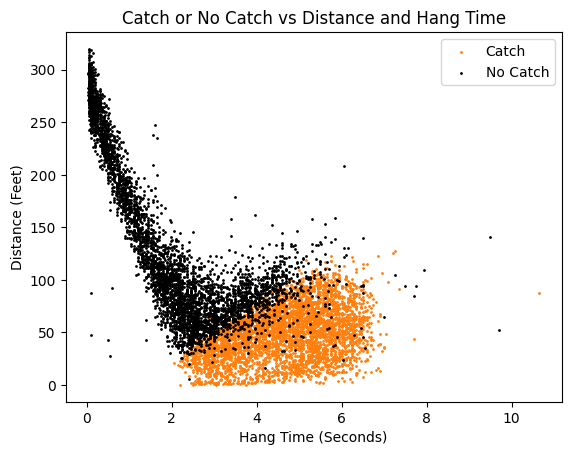

In [79]:
# Figure 2: scatterplot of every play by hang time and distance, colored by whether or not they were caught

fig, ax = plt.subplots()
for color in ["tab:orange", "black"]:
    if color == "tab:orange":
        df = with_caught[with_caught["was_caught"]]
        ax.scatter(df["hang_time"] / 1000, df["bounce_dist"], c=color, s=1, label="Catch")
    else:
        df = with_caught[-with_caught["was_caught"]]
        ax.scatter(df["hang_time"] / 1000, df["bounce_dist"], c=color, s=1, label="No Catch")

ax.legend()
ax.set_xlabel("Hang Time (Seconds)")
ax.set_ylabel("Distance (Feet)")
ax.set_title("Catch or No Catch vs Distance and Hang Time")

plt.show()

In [80]:
# Compiles a table of all "subroutes." A "subroute" is simply a single moment during a play. It's what gets fed into the DCP neural network.

subroutes = Route.get_all_subroutes_df()

In [81]:
# creates the DCP neural network and trains it

cont_mod = Model.create_cont_model(subroutes)

In [82]:
# adds the Dynamic Catch Probabilities from the neural network

with_pred = pd.concat([subroutes.reset_index(), pd.DataFrame(cont_mod.predict_proba(subroutes))], axis = 1)

In [83]:
# rounds the probabilities to the nearest five percent

with_pred["pred"] = np.round(with_pred[1] * 20) / 20
with_pred = with_pred.drop(columns = ["index"])

In [84]:
# assigns each play a unique id, this is the id used to define the specific example plays

with_pred["unique_id"] = with_pred["route_obj"] == with_pred["route_obj"].shift(1)
with_pred["unique_id"] = with_pred["unique_id"].apply(lambda x: np.nan if x else 1)
with_pred["unique_id"] = (with_pred["unique_id"] * range(with_pred.shape[0])).ffill()

In [85]:
# adds a flag for new routes (as opposed to the next timestamp in the same route)

with_pred["new"] = with_pred["unique_id"] != with_pred["unique_id"].shift(1)

In [86]:
# query to find good examples

with_pred.groupby("unique_id").filter(lambda x: x["pred"].iloc[0] <= .60 and x["pred"].iloc[0] >= .40 and x["quarter_sec_velo"].iloc[1] < 0 and x["was_caught"].iloc[0])

,route_obj,distance_remaining,hang_time_remaining,updated_direction,quarter_sec_velo,was_caught,0,1,pred,unique_id,new
5601,<Team57_code_Route.Route object at 0x000001ADD...,57.822279,3100,left,0.000000,True,0.457245,0.542755,0.55,5601.0,True
5602,<Team57_code_Route.Route object at 0x000001ADD...,58.089411,2850,left,-1.093285,True,0.913374,0.086626,0.10,5601.0,False
5603,<Team57_code_Route.Route object at 0x000001ADD...,56.420077,2600,left,6.668544,True,0.288005,0.711995,0.70,5601.0,False
5604,<Team57_code_Route.Route object at 0x000001ADD...,53.303462,2350,left,12.464307,True,0.095206,0.904794,0.90,5601.0,False
5605,<Team57_code_Route.Route object at 0x000001ADD...,49.723450,2100,left,14.319309,True,0.180101,0.819899,0.80,5601.0,False
...,...,...,...,...,...,...,...,...,...,...,...
120148,<Team57_code_Route.Route object at 0x000001AF0...,26.905631,1000,back,26.906717,True,0.179869,0.820131,0.80,120131.0,False
120149,<Team57_code_Route.Route object at 0x000001AF0...,20.179199,750,back,26.905728,True,0.129760,0.870240,0.85,120131.0,False
120150,<Team57_code_Route.Route object at 0x000001AF0...,13.452815,500,back,26.905533,True,0.097650,0.902350,0.90,120131.0,False
120151,<Team57_code_Route.Route object at 0x000001AF0...,6.726383,250,back,26.905728,True,0.045471,0.954529,0.95,120131.0,False


,route_obj,distance_remaining,hang_time_remaining,updated_direction,quarter_sec_velo,was_caught,0,1,pred,unique_id,new
hang_time_remaining,,,,,,,,,,,
0.00,<Team57_code_Route.Route object at 0x000001AF0...,99.210284,5250,back,0.000000,True,0.414445,0.585555,0.60,120131.0,True
0.25,<Team57_code_Route.Route object at 0x000001AF0...,99.974244,5000,back,-3.058589,True,0.777202,0.222798,0.20,120131.0,False
0.50,<Team57_code_Route.Route object at 0x000001AF0...,100.360641,4750,back,-1.551634,True,0.875209,0.124791,0.10,120131.0,False
0.75,<Team57_code_Route.Route object at 0x000001AF0...,100.002487,4500,back,1.420002,True,0.868889,0.131111,0.15,120131.0,False
1.00,<Team57_code_Route.Route object at 0x000001AF0...,98.465393,4250,back,6.129398,True,0.673396,0.326604,0.35,120131.0,False
1.25,<Team57_code_Route.Route object at 0x000001AF0...,95.592382,4000,back,11.471854,True,0.498409,0.501591,0.50,120131.0,False
1.50,<Team57_code_Route.Route object at 0x000001AF0...,91.525292,3750,back,16.252649,True,0.382980,0.617020,0.60,120131.0,False
1.75,<Team57_code_Route.Route object at 0x000001AF0...,86.561507,3500,back,19.846087,True,0.282344,0.717656,0.70,120131.0,False
2.00,<Team57_code_Route.Route object at 0x000001AF0...,81.012602,3250,back,22.192131,True,0.213218,0.786782,0.80,120131.0,False


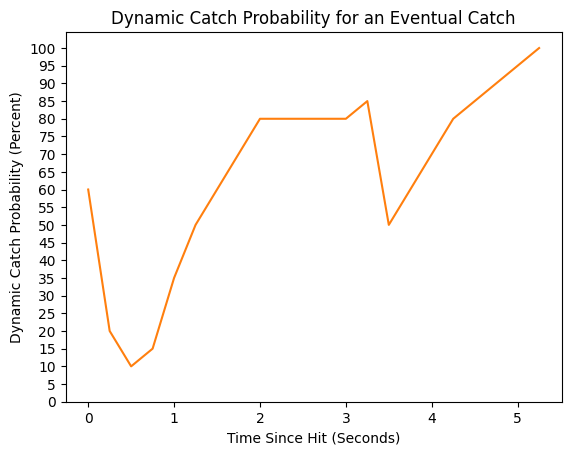

In [87]:
# Figure 5: Dynamic Catch Probability for a catch

example_id1 = 120131
example_id2 = 123527
ex1df = with_pred[with_pred["unique_id"] == example_id1]
ex1df.index = (ex1df["hang_time_remaining"].iloc[0] - ex1df["hang_time_remaining"]) / 1000
fig, ax = plt.subplots()
ax.plot(ex1df["pred"] * 100, c = "tab:orange")
ax.set_xlabel("Time Since Hit (Seconds)")
ax.set_ylabel("Dynamic Catch Probability (Percent)")
ax.set_title("Dynamic Catch Probability for an Eventual Catch")
ax.set_yticks(np.arange(0, 101, 5))
ex1df

MovieWriter imagemagick unavailable; using Pillow instead.


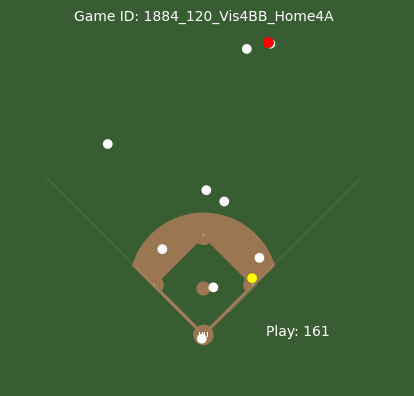

In [88]:
# Figure 6: Animation of the previous example

with_pred[with_pred["unique_id"] == example_id1]["route_obj"].iloc[0].visualize(save = True)

,route_obj,distance_remaining,hang_time_remaining,updated_direction,quarter_sec_velo,was_caught,0,1,pred,unique_id,new
hang_time_remaining,,,,,,,,,,,
0.00,<Team57_code_Route.Route object at 0x000001AF0...,47.949461,2750,right,0.000000,False,0.402429,5.975707e-01,0.60,123527.0,True
0.25,<Team57_code_Route.Route object at 0x000001AF0...,47.466420,2500,right,1.932087,False,0.416143,5.838574e-01,0.60,123527.0,False
0.50,<Team57_code_Route.Route object at 0x000001AF0...,46.683959,2250,right,3.129057,False,0.627161,3.728395e-01,0.35,123527.0,False
0.75,<Team57_code_Route.Route object at 0x000001AF0...,45.608567,2000,right,4.294992,False,0.856852,1.431483e-01,0.15,123527.0,False
1.00,<Team57_code_Route.Route object at 0x000001AF0...,43.047686,1750,right,10.096496,False,0.703261,2.967395e-01,0.30,123527.0,False
1.25,<Team57_code_Route.Route object at 0x000001AF0...,40.249588,1500,right,10.946491,False,0.903396,9.660412e-02,0.10,123527.0,False
1.50,<Team57_code_Route.Route object at 0x000001AF0...,37.970313,1250,right,8.500667,False,0.997656,2.344107e-03,0.00,123527.0,False
1.75,<Team57_code_Route.Route object at 0x000001AF0...,36.369168,1000,right,5.345179,False,0.999993,6.641245e-06,0.00,123527.0,False
2.00,<Team57_code_Route.Route object at 0x000001AF0...,35.373509,750,right,2.700343,False,1.000000,7.049855e-09,0.00,123527.0,False


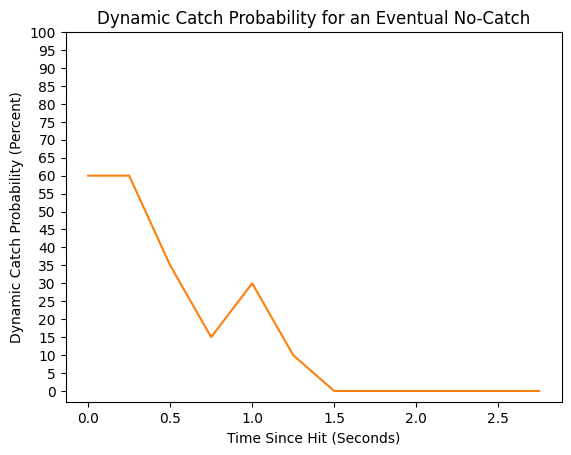

In [89]:
# Figure 7: Dynamic Catch Probability of a no-catch

ex2df = with_pred[with_pred["unique_id"] == example_id2]
ex2df.index = (ex2df["hang_time_remaining"].iloc[0] - ex2df["hang_time_remaining"]) / 1000
fig, ax = plt.subplots()
ax.plot(ex2df["pred"] * 100, c = "tab:orange")
ax.set_xlabel("Time Since Hit (Seconds)")
ax.set_ylabel("Dynamic Catch Probability (Percent)")
ax.set_title("Dynamic Catch Probability for an Eventual No-Catch")
ax.set_yticks(np.arange(0, 101, 5))
ex2df

MovieWriter imagemagick unavailable; using Pillow instead.


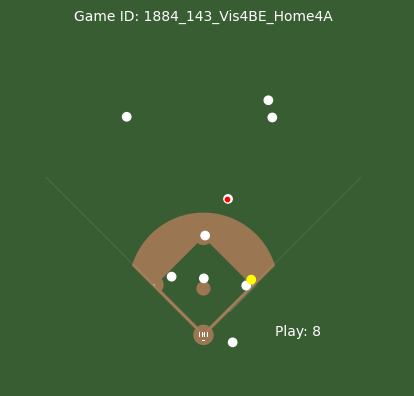

In [90]:
# Figure 8: Animation of previous example

with_pred[with_pred["unique_id"] == example_id2]["route_obj"].iloc[0].visualize(save = True)

In [91]:
# adds the overall hang time to each route (previously only hang time remaining was included)

with_pred["orig_hang_time"] = with_pred["hang_time_remaining"] * with_pred["new"].apply(lambda x: 1 if x else np.nan)
with_pred["orig_hang_time"] = with_pred["orig_hang_time"].ffill()
with_pred["time_elapsed"] = with_pred["orig_hang_time"] - with_pred["hang_time_remaining"]

C:\Users\Owner\AppData\Local\Temp\ipykernel_35780\3163332425.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  with_pred[(with_pred["orig_hang_time"] < 8000)][["unique_id", "time_elapsed", "pred", "orig_hang_time"]].groupby("unique_id").apply(lambda x: ax.plot(x["time_elapsed"] / 1000, x["pred"] * 100, c = "black", alpha = 0.01))


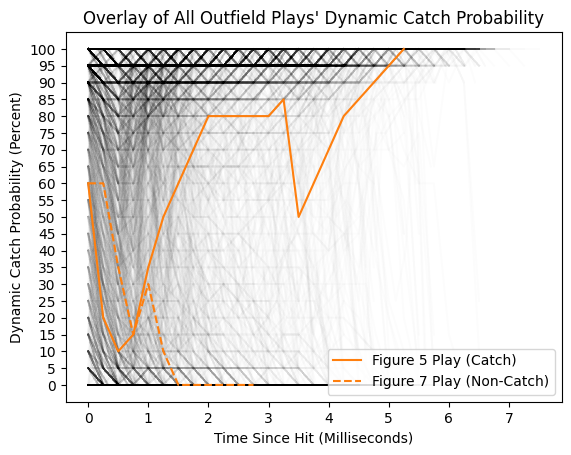

In [92]:
# Figure 9: All DCPs overlaid

fig, ax = plt.subplots()
with_pred[(with_pred["orig_hang_time"] < 8000)][["unique_id", "time_elapsed", "pred", "orig_hang_time"]].groupby("unique_id").apply(lambda x: ax.plot(x["time_elapsed"] / 1000, x["pred"] * 100, c = "black", alpha = 0.01))
ax.plot(with_pred[with_pred["unique_id"] == example_id1]["time_elapsed"] / 1000, with_pred[with_pred["unique_id"] == example_id1]["pred"] * 100, color = "tab:orange", linestyle = "-", label = "Figure 5 Play (Catch)")
ax.plot(with_pred[with_pred["unique_id"] == example_id2]["time_elapsed"] / 1000, with_pred[with_pred["unique_id"] == example_id2]["pred"] * 100, color = "tab:orange", linestyle = "--", label = "Figure 7 Play (Non-Catch)")
ax.set_title("Overlay of All Outfield Plays' Dynamic Catch Probability")
ax.set_xlabel("Time Since Hit (Milliseconds)")
ax.set_yticks(np.arange(0, 101, 5))
ax.set_ylabel("Dynamic Catch Probability (Percent)")
ax.legend(loc = "lower right")

C:\Users\Owner\AppData\Local\Temp\ipykernel_35780\1522937063.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  with_pred[(with_pred["orig_hang_time"] <= 5000) & (with_pred["orig_hang_time"] >= 4000)][["unique_id", "time_elapsed", "pred", "orig_hang_time"]].groupby("unique_id").apply(lambda x: ax.plot(x["time_elapsed"] / 1000, x["pred"] * 100, c = "black", alpha = 0.01))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


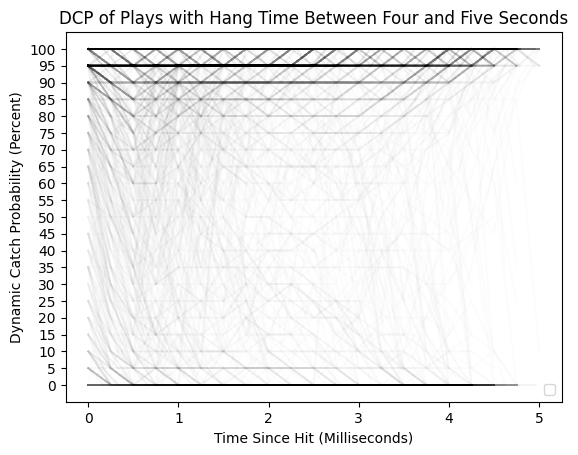

In [93]:
# Figure 19: DCPs overlaid but only for plays that had a hang time between 4 and 5 seconds

fig, ax = plt.subplots()
with_pred[(with_pred["orig_hang_time"] <= 5000) & (with_pred["orig_hang_time"] >= 4000)][["unique_id", "time_elapsed", "pred", "orig_hang_time"]].groupby("unique_id").apply(lambda x: ax.plot(x["time_elapsed"] / 1000, x["pred"] * 100, c = "black", alpha = 0.01))
ax.set_title("DCP of Plays with Hang Time Between Four and Five Seconds")
ax.set_xlabel("Time Since Hit (Milliseconds)")
ax.set_yticks(np.arange(0, 101, 5))
ax.set_ylabel("Dynamic Catch Probability (Percent)")
ax.legend(loc = "lower right")

In [94]:
# loads in the MLB data on jumps and sprint speeds

mlbjumps = pd.read_csv("jump.csv")
mlbspeeds = pd.read_csv("sprint_speed.csv")

In [95]:
# combines the two tables so that we have jumps and speeds for each player

jump_and_speed = mlbjumps.merge(mlbspeeds, on = "last_name, first_name")

In [96]:
# finds highest and lowest players by outs above average

jump_and_speed.sort_values("outs_above_average")

,"last_name, first_name",resp_fielder_id,year,outs_above_average,outs_per_play,rel_league_burst_distance,rel_league_reaction_distance,rel_league_routing_distance,rel_league_bootup_distance,f_bootup_distance,...,n_outs,player_id,team_id,team,position,age,competitive_runs,bolts,hp_to_1b,sprint_speed
56,"Marte, Starling",516782,2024,-9,30.0,-1.1,-0.7,0.4,-1.5,32.0,...,9,516782,121,NYM,RF,35,108,3.0,4.36,26.7
33,"García, Adolis",666969,2024,-7,30.0,-0.8,0.1,-0.2,-0.8,33.1,...,12,666969,140,TEX,RF,31,136,NaN,4.54,26.6
2,"Andujar, Miguel",609280,2024,-7,25.8,-1.8,1.5,-1.8,-2.1,32.0,...,8,609280,133,OAK,LF,29,117,NaN,4.64,26.4
3,"Arozarena, Randy",668227,2024,-7,34.0,-1.8,-0.5,0.2,-2.0,31.4,...,17,668227,136,SEA,LF,29,138,4.0,4.33,28.0
72,"Profar, Jurickson",595777,2024,-7,32.6,-1.9,0.1,-0.5,-2.4,30.4,...,14,595777,135,SD,LF,31,148,NaN,4.44,26.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50,"Kiermaier, Kevin",595281,2024,8,77.3,2.2,0.8,0.5,3.5,38.4,...,34,595281,119,LAD,CF,34,86,NaN,4.29,28.6
87,"Siri, Jose",642350,2024,9,72.7,2.2,1.3,-0.3,3.2,38.2,...,40,642350,139,TB,CF,28,89,28.0,4.22,29.9
100,"Varsho, Daulton",662139,2024,10,67.2,2.1,1.6,0.1,3.8,37.8,...,45,662139,141,TOR,LF,27,94,NaN,4.26,28.4
86,"Siani, Michael",672279,2024,12,83.0,2.0,1.7,-0.6,3.1,37.4,...,39,672279,138,STL,CF,24,101,1.0,4.29,28.4


In [97]:
# finds highest and lowest average jumps

jump_and_speed.sort_values("rel_league_bootup_distance")

,"last_name, first_name",resp_fielder_id,year,outs_above_average,outs_per_play,rel_league_burst_distance,rel_league_reaction_distance,rel_league_routing_distance,rel_league_bootup_distance,f_bootup_distance,...,n_outs,player_id,team_id,team,position,age,competitive_runs,bolts,hp_to_1b,sprint_speed
103,"Winker, Jesse",608385,2024,-6,38.7,-2.3,-1.5,0.1,-3.7,30.0,...,12,608385,121,NYM,LF,30,130,NaN,4.63,26.1
47,"Judge, Aaron",592450,2024,-5,40.0,-2.3,-1.1,0.3,-3.1,31.1,...,16,592450,147,NYY,CF,32,116,NaN,4.78,26.8
31,"Freeman, Tyler",671289,2024,-4,41.4,-1.6,-1.5,0.3,-2.8,31.5,...,12,671289,114,CLE,CF,25,138,NaN,4.49,28.2
75,"Raley, Luke",670042,2024,-5,42.9,-2.1,-0.8,0.2,-2.8,30.4,...,12,670042,136,SEA,LF,29,100,2.0,4.31,29.0
15,"Castellanos, Nick",592206,2024,-5,38.9,-1.8,-0.9,-0.1,-2.7,30.2,...,14,592206,143,PHI,RF,32,136,NaN,4.50,27.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21,"Crow-Armstrong, Pete",691718,2024,6,75.0,2.6,0.5,0.3,3.3,37.8,...,30,691718,112,CHC,CF,22,84,41.0,4.09,30.0
106,"Young, Jacob",696285,2024,14,76.2,1.7,4.5,-2.8,3.4,38.2,...,48,696285,120,WSH,CF,24,155,44.0,4.19,29.7
50,"Kiermaier, Kevin",595281,2024,8,77.3,2.2,0.8,0.5,3.5,38.4,...,34,595281,119,LAD,CF,34,86,NaN,4.29,28.6
63,"Meyers, Jake",676694,2024,8,75.6,2.1,1.0,0.3,3.5,38.2,...,31,676694,117,HOU,CF,28,112,1.0,4.36,28.8


In [98]:
# finds the player with a low sprint speed but high outs above average

jump_and_speed[(jump_and_speed["sprint_speed"] < 26.85) & (jump_and_speed["outs_above_average"] > 2)]

,"last_name, first_name",resp_fielder_id,year,outs_above_average,outs_per_play,rel_league_burst_distance,rel_league_reaction_distance,rel_league_routing_distance,rel_league_bootup_distance,f_bootup_distance,...,n_outs,player_id,team_id,team,position,age,competitive_runs,bolts,hp_to_1b,sprint_speed
38,"Gurriel Jr., Lourdes",666971,2024,3,65.5,0.7,1.2,-0.1,1.8,35.6,...,36,666971,109,AZ,LF,30,147,NaN,4.6,26.8


Text(1.8, 2, 'Gurriel Jr.')

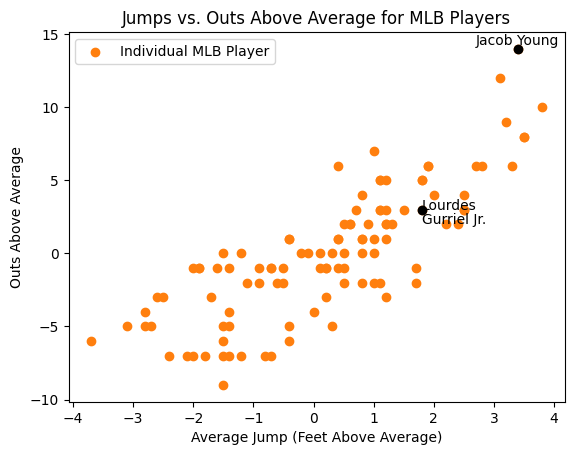

In [99]:
# Figure 11: scatterplot of every qualified mlb player's jumps and outs above average

fig, ax = plt.subplots()
ax.scatter(jump_and_speed["rel_league_bootup_distance"], jump_and_speed["outs_above_average"], color = "tab:orange", label = "Individual MLB Player")
ax.set_title("Jumps vs. Outs Above Average for MLB Players")
ax.legend(loc = "upper left")
ax.set_xlabel("Average Jump (Feet Above Average)")
ax.set_ylabel("Outs Above Average")
ax.scatter(3.4, 14, color = "black")
ax.text(2.7, 14.3, "Jacob Young")
ax.scatter(1.8, 3, color = "black")
ax.text(1.8, 3, "Lourdes")
ax.text(1.8, 2, "Gurriel Jr.")

Text(29.7, 12, 'Young')

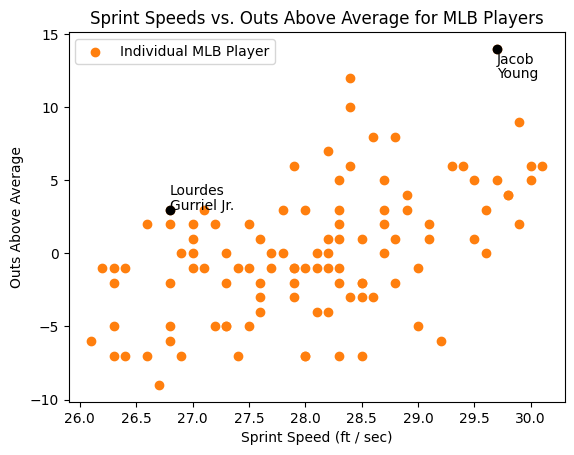

In [100]:
# Figure 10: scatterplot for sprint speed and outs above average

fig, ax = plt.subplots()
ax.scatter(jump_and_speed["sprint_speed"], jump_and_speed["outs_above_average"], color = "tab:orange", label = "Individual MLB Player")
ax.set_title("Sprint Speeds vs. Outs Above Average for MLB Players")
ax.legend(loc = "upper left")
ax.set_xlabel("Sprint Speed (ft / sec)")
ax.set_ylabel("Outs Above Average")
ax.scatter(26.8, 3, color = "black")
ax.text(26.8, 4, "Lourdes")
ax.text(26.8, 3, "Gurriel Jr.")
ax.scatter(29.7, 14, color = "black")
ax.text(29.7, 13, "Jacob")
ax.text(29.7, 12, "Young")

In [101]:
# creates non-dynamic model that is used to replicate regular Catch Probability

mod = Model.create_model(with_caught)

In [102]:
# finds only plays with a Catch Probability strictly less than 100% and strictly greater than 5%

with_disc_pred = with_caught.assign(pred = list(map(lambda x: x[1], mod.predict_proba(with_caught))))
with_disc_pred["pred"] = np.round(with_disc_pred["pred"] * 20) / 20
hard_only = with_disc_pred[(with_disc_pred["pred"] < 1) & (with_disc_pred["pred"] > .05)]
hard_only

,route_obj,game_str,player_id,position,level,ideal_length,direction,bounce_dist,statcast jump,route efficiency,hang_time,was_caught,pred
1,<Team57_code_Route.Route object at 0x000001ADA...,1883_001_Vis1AB_Home1A,492,7.0,1A,59.028671,forward,59.028671,29.431072,0.896665,5150,True,0.95
3,<Team57_code_Route.Route object at 0x000001AE1...,1883_001_Vis1AB_Home1A,-1,8.0,1A,60.843784,forward,60.843784,46.980509,0.878222,3550,True,0.45
5,<Team57_code_Route.Route object at 0x000001AE1...,1883_001_Vis1AB_Home1A,-1,9.0,1A,82.841640,right,82.841640,41.098048,0.989837,4500,True,0.75
6,<Team57_code_Route.Route object at 0x000001AE1...,1883_001_Vis1AB_Home1A,-1,8.0,1A,47.603245,left,47.603245,43.366998,0.913358,3150,True,0.90
7,<Team57_code_Route.Route object at 0x000001AE1...,1883_001_Vis1AB_Home1A,-1,9.0,1A,71.005962,back,71.005962,34.580992,0.935722,4850,True,0.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8294,<Team57_code_Route.Route object at 0x000001AF1...,1884_143_Vis4BE_Home4A,2188,7.0,4A,42.589275,back,42.589275,36.999996,0.985354,3700,True,0.95
8295,<Team57_code_Route.Route object at 0x000001AF1...,1884_143_Vis4BE_Home4A,502,9.0,4A,53.289710,left,53.289710,47.233056,0.984911,3200,True,0.65
8296,<Team57_code_Route.Route object at 0x000001AF1...,1884_143_Vis4BE_Home4A,8801,8.0,4A,96.687626,left,96.687626,46.816930,0.991299,5300,True,0.95
8297,<Team57_code_Route.Route object at 0x000001AF1...,1884_143_Vis4BE_Home4A,6466,9.0,4A,50.863998,right,50.863998,18.078479,0.883312,5800,True,0.95


Text(0.5, 1.0, 'Box Plots of Jumps for each Play Separated by Farm System Level')

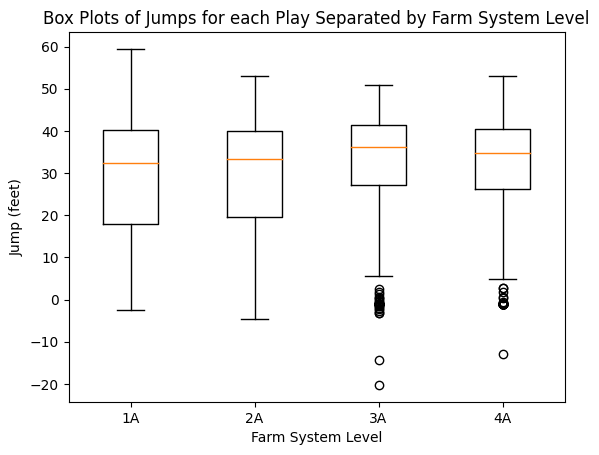

In [103]:
# Figure 12: box plots for each minor league level's jumps

fig, ax = plt.subplots()
ax.boxplot([hard_only[hard_only["level"] == "1A"]["statcast jump"],
           hard_only[hard_only["level"] == "2A"]["statcast jump"],
           hard_only[hard_only["level"] == "3A"]["statcast jump"],
           hard_only[hard_only["level"] == "4A"]["statcast jump"]])
ax.set_xticklabels(["1A", "2A", "3A", "4A"])
ax.set_ylabel("Jump (feet)")
ax.set_xlabel("Farm System Level")
ax.set_title("Box Plots of Jumps for each Play Separated by Farm System Level")

Text(0.5, 0, 'Farm System Level')

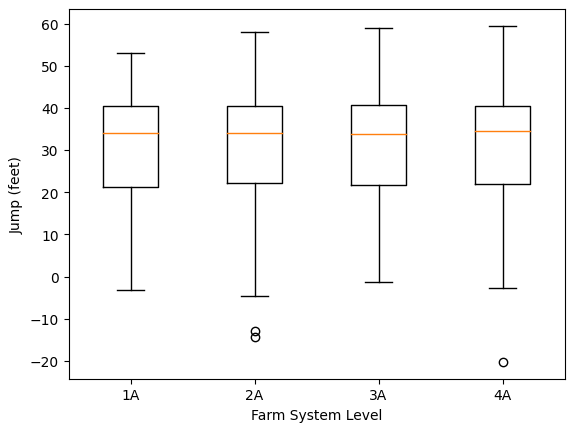

In [104]:
# the same box plot as above but with shuffled farm system levels, it looks basically the same meaning that there is no trend

shuffled = hard_only.assign(level = hard_only["level"].sample(frac = 1).to_numpy())
fig, ax = plt.subplots()
ax.boxplot([shuffled[shuffled["level"] == "1A"]["statcast jump"],
           shuffled[shuffled["level"] == "2A"]["statcast jump"],
           shuffled[shuffled["level"] == "3A"]["statcast jump"],
           shuffled[shuffled["level"] == "4A"]["statcast jump"]])
ax.set_xticklabels(["1A", "2A", "3A", "4A"])
ax.set_ylabel("Jump (feet)")
ax.set_xlabel("Farm System Level")

In [105]:
# turns the probabilities into binary predictions.
# slightly inaccurate due to double rounding

with_disc_pred["binary_pred"] = with_disc_pred["pred"].apply(lambda x: 0 if x < .5 else 1)

In [106]:
# Figure 18: confusion matrix for my model

with_disc_pred[["route_obj", "was_caught", "binary_pred"]].assign(binary_pred = with_disc_pred["binary_pred"].apply(lambda x: "No Catch" if x == 0 else "Catch")).groupby(["was_caught", "binary_pred"]).count().reset_index().pivot(index="was_caught", columns="binary_pred", values="route_obj")

binary_pred,Catch,No Catch
was_caught,,
False,246,4001
True,3968,84


In [107]:
(399 + 3941)/ (4017 + 230 + 3941 + 111)

0.5229545728401012

Text(0.5, 1.0, 'Every Outfield Play')

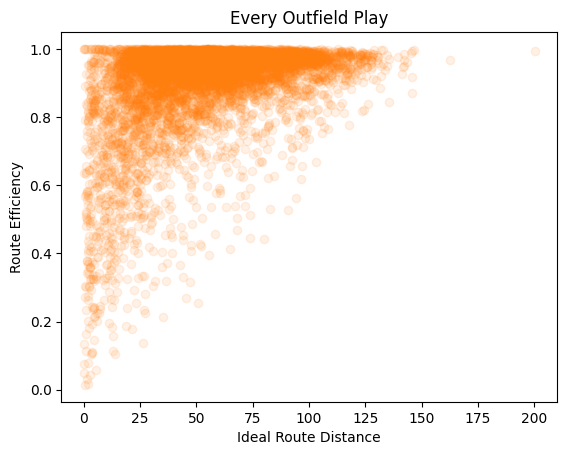

In [108]:
# Figure 13: scatterplot of every play by distance and route efficiency

fig, ax = plt.subplots()
ax.scatter(all_routes_df["ideal_length"], all_routes_df["route efficiency"], color = "tab:orange", alpha = 0.1)
ax.set_xlabel("Ideal Route Distance")
ax.set_ylabel("Route Efficiency")
ax.set_title("Every Outfield Play")

In [109]:
# conducts a permutation test on the jump statistic
# commented out due to high runtime, p value results are in main paper


# Metric.statcast_jump.test_metric()

In [110]:
# compiles all routes again

all_routes_df = Route.get_all_routes_df()

C:\Users\Owner\AppData\Local\Temp\ipykernel_35780\155928622.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(44, 0, -1)), rotation = 70, fontsize = 8)


Text(0.5, 0, 'Average Jump Rank')

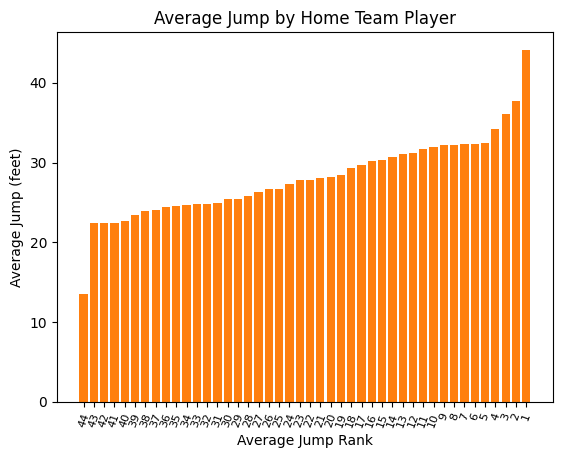

In [111]:
# Figure 16: jump distribution

df = all_routes_df[all_routes_df["player_id"].apply(lambda x: len(str(x)) == 3)][["player_id", "statcast jump"]].groupby("player_id").mean().sort_values("statcast jump").reset_index()
fig, ax = plt.subplots()
ax.bar(df["player_id"].apply(str), df["statcast jump"], color = "tab:orange")
ax.set_xticklabels(list(range(44, 0, -1)), rotation = 70, fontsize = 8)
ax.set_title("Average Jump by Home Team Player")
ax.set_ylabel("Average Jump (feet)")
ax.set_xlabel("Average Jump Rank")

C:\Users\Owner\AppData\Local\Temp\ipykernel_35780\587310998.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(44, 0, -1)), rotation = 70, fontsize = 8)


Text(0.5, 0, 'Average Jump Rank')

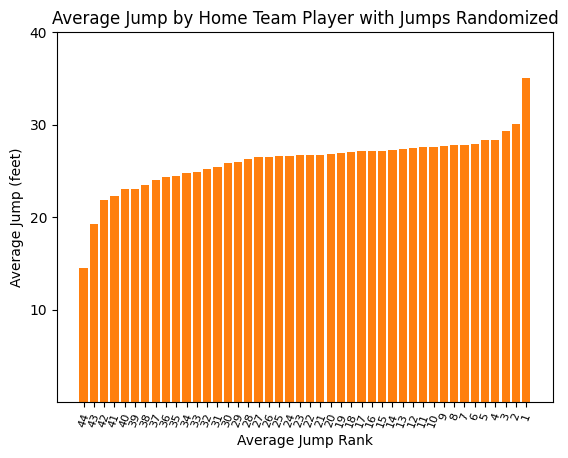

In [112]:
# Figure 17: randomized distribution

shuffled = all_routes_df.assign(shuffled = all_routes_df["statcast jump"].sample(frac = 1).to_numpy())
shuffled = shuffled[shuffled["player_id"].apply(lambda x: len(str(x)) == 3)][["player_id", "shuffled"]].groupby("player_id").mean().sort_values("shuffled").reset_index()
df = shuffled
fig, ax = plt.subplots()
ax.bar(df["player_id"].apply(str), df["shuffled"], color = "tab:orange")
ax.set_xticklabels(list(range(44, 0, -1)), rotation = 70, fontsize = 8)
ax.set_yticks([10, 20, 30, 40])
ax.set_title("Average Jump by Home Team Player with Jumps Randomized")
ax.set_ylabel("Average Jump (feet)")
ax.set_xlabel("Average Jump Rank")

In [113]:
# conducts a permutation test on the route efficiency statistic
# commented out due to high run time, p value results are in main paper

# Metric.route_efficiency.test_metric()

C:\Users\Owner\AppData\Local\Temp\ipykernel_35780\355769849.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(44, 0, -1)), rotation = 70, fontsize = 8)


Text(0.5, 0, 'Average Route Efficiency Rank')

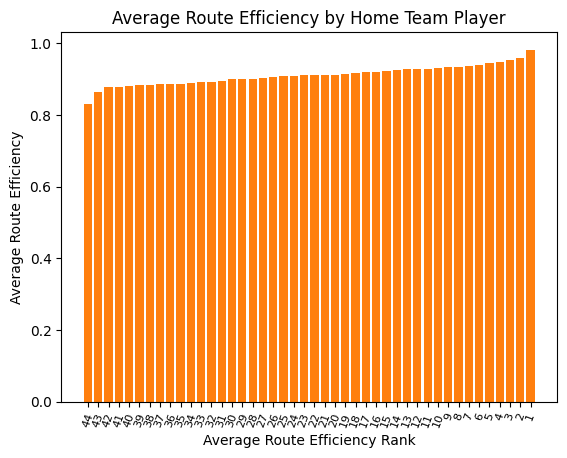

In [114]:
# Figure 14: route efficiency distribution

df = all_routes_df[all_routes_df["player_id"].apply(lambda x: len(str(x)) == 3)][["player_id", "route efficiency"]].groupby("player_id").mean().sort_values("route efficiency").reset_index()
fig, ax = plt.subplots()
ax.bar(df["player_id"].apply(str), df["route efficiency"], color = "tab:orange")
ax.set_xticklabels(list(range(44, 0, -1)), rotation = 70, fontsize = 8)
ax.set_title("Average Route Efficiency by Home Team Player")
ax.set_ylabel("Average Route Efficiency")
ax.set_xlabel("Average Route Efficiency Rank")

C:\Users\Owner\AppData\Local\Temp\ipykernel_35780\2974430700.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(44, 0, -1)), rotation = 70, fontsize = 8)


Text(0.5, 0, 'Average Route Efficiency Rank')

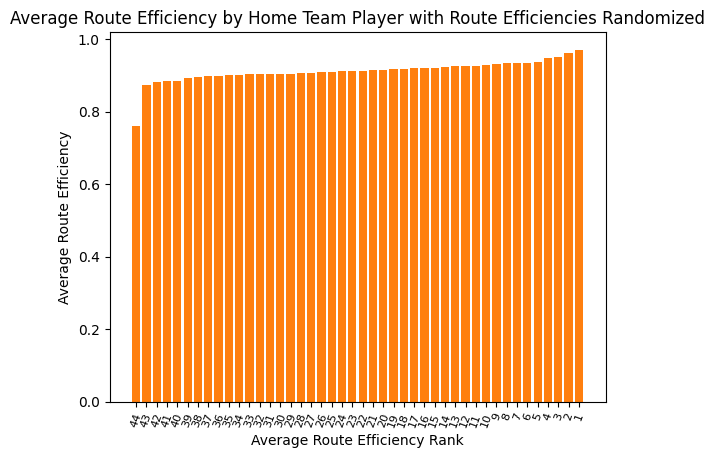

In [115]:
# Figure 15: randomized route efficiency distribution

shuffled = all_routes_df.assign(shuffled = all_routes_df["route efficiency"].sample(frac = 1).to_numpy())
shuffled = shuffled[shuffled["player_id"].apply(lambda x: len(str(x)) == 3)][["player_id", "shuffled"]].groupby("player_id").mean().sort_values("shuffled").reset_index()
df = shuffled
fig, ax = plt.subplots()
ax.bar(df["player_id"].apply(str), df["shuffled"], color = "tab:orange")
ax.set_xticklabels(list(range(44, 0, -1)), rotation = 70, fontsize = 8)
ax.set_title("Average Route Efficiency by Home Team Player with Route Efficiencies Randomized")
ax.set_ylabel("Average Route Efficiency")
ax.set_xlabel("Average Route Efficiency Rank")

In [116]:
# function to find the direction given a starting position and ending position

def find_direction(start, end):
    direcvec = (end[0] - start[0], end[1] - start[1])
    angle = np.arctan2(start[1], start[0]) - np.arctan2(direcvec[1], direcvec[0])
    if angle < 0:
        angle = angle + 2 * np.pi
    if angle <= np.pi / 4 or angle > 7 * np.pi / 4:
        return "back"
    elif angle <= 3 *np.pi / 4:
        return "left"
    elif angle <= 5 * np.pi / 4:
        return "forward"
    else:
        return "right"

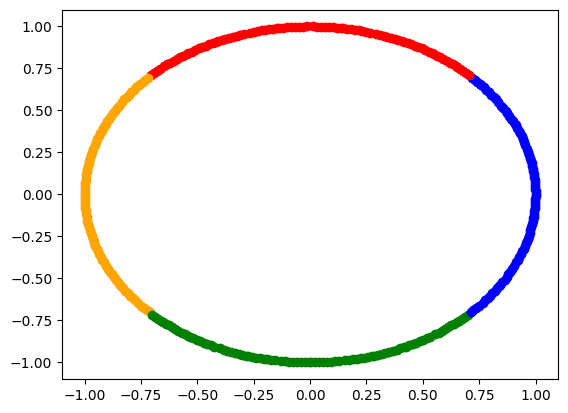

In [117]:
# Figure 21: directions visualized

fig, ax = plt.subplots()
colordic = {"forward": "orange",
            "back": "blue",
            "left": "green",
            "right": "red"}
for i in range(360):
    ax.scatter(np.cos(i), np.sin(i), color = colordic[find_direction([0, 0], [np.cos(i), np.sin(i)])])